OCR = Text detection + Text recognition
***

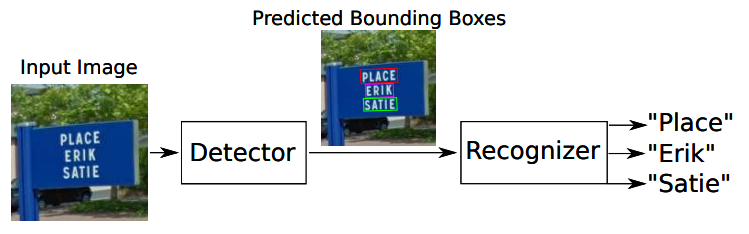

***
### 16-2. Before Deep Learning
### 16-3. Text detection
### 16-4. Text recognition
### 16-5. Text recognition + Attention
***

## 16 - 2. Before Deep Learning
***
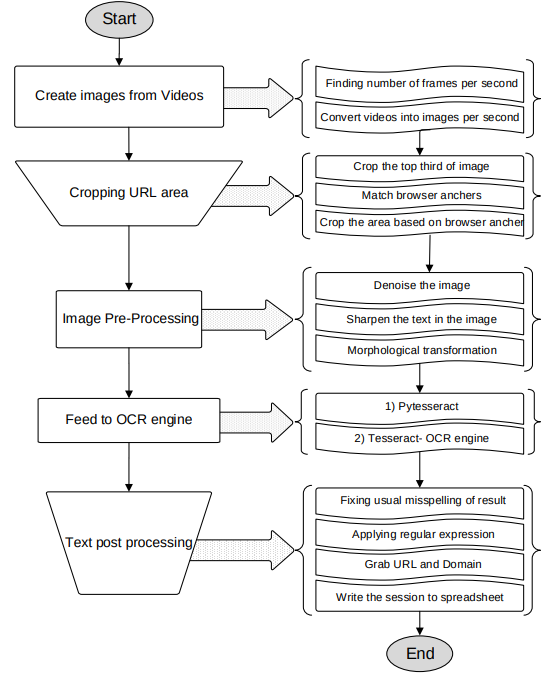

위 그림은 크게 5단계로 나뉘어 있는데, 위 3단계는 입력 이미지 추출과 전처리, 4번째 단계는 OCR 처리, 마지막 5번째 단계는 OCR의 출력 텍스트의 후처리로 구성된다. 여기서 Tesseract OCR을 통한 4단계의 과정을 아래 그림과 같이 정리하였다.

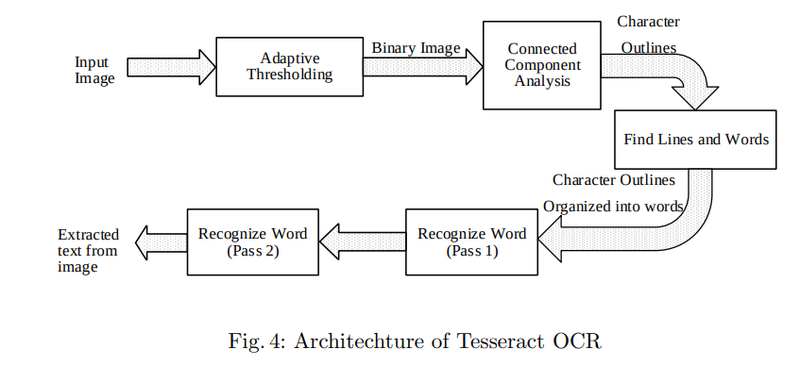

먼저 **Adaptive Thresholding** 단계에서 입력 영상의 이진화를 통해 흑백으로 변환한다. 이후 **Connected Component Analysis** 단계에서 문자 영역을 검출한 후 **Find Lines and Words**에서 라인 또는 단어 단위를 추출한다. 이후 **Recognize Word** 단계에서 단어(Word) 단위 이미지를 Text로 변환하기 위해 문자를 하나씩 인식하고 다시 결합하는 과정을 거친다.

## 16 - 3. Text detection
***

이제 딥러닝을 이용해 이미지에서 텍스트의 위치를 찾는 Text detection의 방법에 대해 생각해 보자. 첫 스텝에서 간단히 생각해 본 것처럼, **Object detection이나 Segmentation**을 위한 기법들을 떠올릴 수 있다. 하지만 이미지 속에서 물체를 찾아낼 때 문자는 조금 다른 특성을 가지고 있다. 문자는 몇 개가 모여서 단어 혹은 문장을 이루고 있어서 이미지 내에서 문자를 검출해낼 때엔 검출하기 위한 **최소 단위**를 정해야 한다.

예를 들어 이미지 속에서 문장 단위로 위치를 찾겠다 혹은 단어나 글자 단위로 위치를 찾겠다고 정할 수 있다. 문장 또는 단어 단위로 찾아낼 경우, 엄청나게 긴 단어나 문장과 함께 짧은 길이도 찾아낼 수 있도록 해야 한다. 반면, 글자 단위로 인식하면 되지 않느냐는 생각을 할 수 있다. 이는 글자를 놓치지 않고 찾아내는 데에는 좋을 수 있지만, 글자를 다시 맥락에 맞게 묶어주는 과정을 거쳐야 한다.

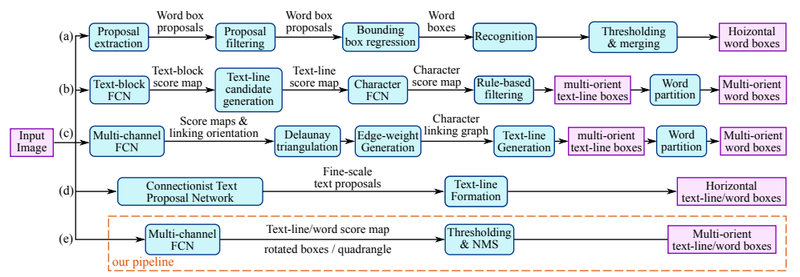

2017년 당시에는 Text의 바운딩 박스를 구하는 방식이 주류를 이루었다. 위 그림을 보면 가로 방향(Horizontal)으로만 텍스트 박스를 구하는 방식이나 기울어지거나 세로 방향 등의 여러 방향(Multi-oriented)의 텍스트 박스를 구하는 방식이 다양하게 소개되고 있다. 해당 논문이 제시하는 (e)의 경우 전체 파이프라인의 길이가 짧고 간결해서 빠르면서도 정확한 Text detection 성능을 보인다고 소개하고 있다.

위 그림을 자세히 보면, 위에서 언급한 단어 단위의 탐지와 글자 단위의 탐지가 모두 활용되고 있다.
**단어 단위의 탐지**는 앞서 배운 Object detection의 Regression 기반의 Detection 방법이다. Anchor를 정의하고 단어의 유무와 Bounding box의 크기를 추정해서 단어를 찾아낸다. **글자 단위의 방식**은 Bounding box regression을 사용하는 대신 글자 영역을 Segmentation하는 방법으로 접근한다. 또한 두 가지 방법을 모두 활용한 방법이 있다.

아래에서는 여러 가지 접근 방식을 시간순이 아니라 대표적인 것을 예가 있다.

***
### 1. Regression
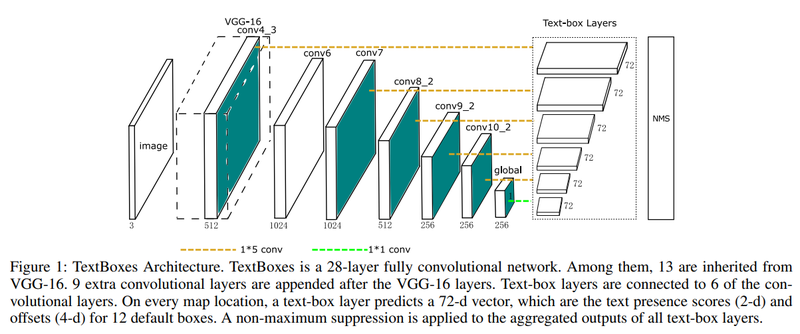
TextBoxes 이전에는 글자 단위로 인식한 후 결합하는 방식을 취해 왔지만 위 논문에서는 딥러닝 기반의 Detection을 이용하여 단어 단위로 인식한다. 네트워크의 기본 구조는 SSD: single shot multibox detector를 활용한 것을 볼 수 있다. 이를 통해서 빠르게 문자 영역을 탐지해 낼 수 있었다고 한다.

일반적으로 단어들은 가로로 길기 때문에 Aspect ratio(종횡비)가 크다. 이에 따라 몇 가지 변형을 주게 되는데요, 기존의 SSD에서는 Regression을 위한 Convolution layer에서 3x3 크기의 kernel을 갖는다.

하지만 여기서는 긴 단어의 Feature를 활용하기 위해서 1x5로 convolution filter를 정의하여 사용한다. Anchor box의 aspect ratio를 1, 2, 3, 5, 7로 만들고, 이에 vertical offset을 적용하여 세로 방향으로 촘촘한 단어의 배열에 대응하도록 했다.

💠 종횡비(Aspect ratio)
종횡비는 가로와 세로 길이의 비를 의미하며, 가로세로비, 영상비, 화면비 등으로 부르기도 한다. 일반적으로 16:9와 같이 '가로:세로'의 형태로 표현한다. 그러나 논문에서는 가로와 세로의 비를 계산하여 하나의 숫자로 표현하고 있다.

💠💠 offset
일반적인 의미의 Offset이란 특정한 값에서 차이가 나는 값 또는 차이를 의미한다. 주의할 점은 offset과 오차가 다르다는 것이다. offset은 차이가 목적에 의해 만들어진 것과 상황에 따라 자연스럽게 발생된 것을 모두 포함하기 때문이다.

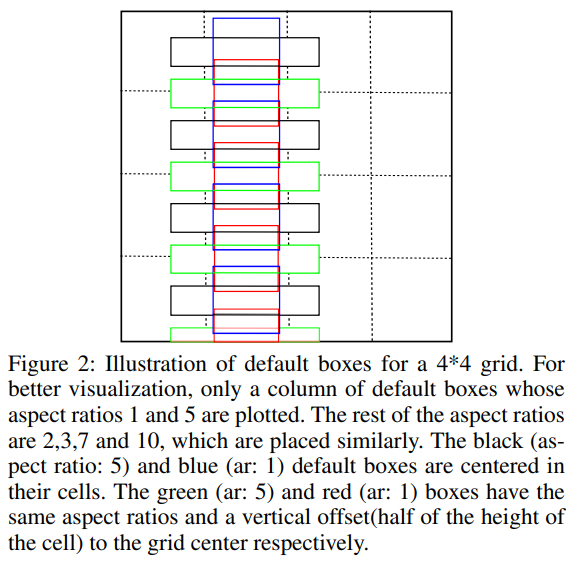

Grid cell의 중앙을 기점으로 생성할 경우를 예로 든 것이 파란색(aspect ratio:1) 그리고 검은색 박스(aspect ratio:5)이다.

그리고 이를 수직방향으로 옮겨서 촘촘하게 만들어준 것이 빨간색과 녹색이다. 수직방향으로 Anchor box의 중앙을 하나 더 둠으로써 세로로 촘촘하게 Anchor box를 배치할 수 있게 된다.
***
다시 정리,

원본 앵커 박스:

    파란색: 앵커 박스의 종횡비(aspect ratio)가 1인 경우 (즉, 가로와 세로의 길이가 같음).
    검은색: 앵커 박스의 종횡비가 5인 경우 (즉, 가로 길이가 세로 길이의 5배).

앵커 박스의 중앙을 기준으로 생성:

각 앵커 박스는 그 중앙을 기준으로 생성된다.

앵커박스의 배치를 수직 방향으로 조절:

    빨간색과 녹색: 앵커 박스를 수직 방향으로 이동하여 격자를 더 촘촘하게 배치한다.
이로써, 세로로 촘촘하게 앵커 박스를 배치할 수 있게 된다.
수직 방향으로 앵커 박스 중앙을 하나 더 둠:

추가적인 중앙 위치를 가진 앵커 박스를 두어, 세로 방향의 다양한 크기와 위치의 객체를 감지할 수 있도록 한다.

***
### 2. Segmentation
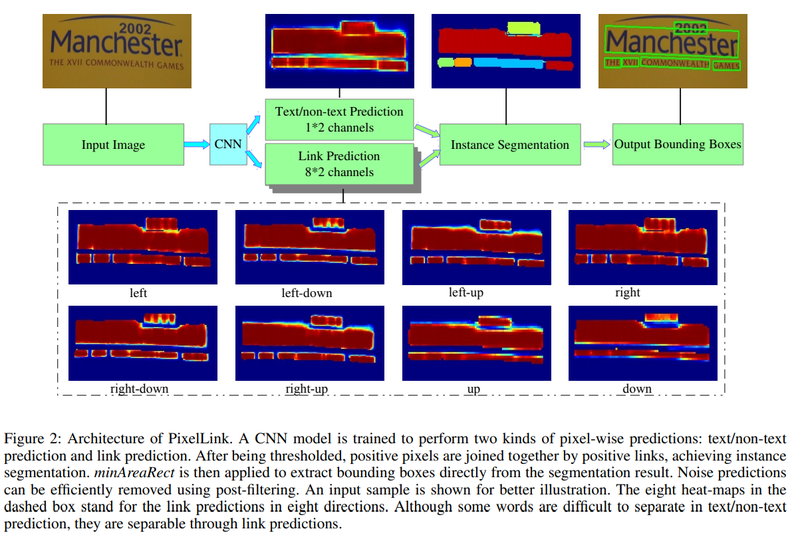

우리는 Semantic segmentation을 이미지 내의 영역을 class로 분리해내는 방법으로 배웠다. 이 방법을 문자의 영역을 찾기 위해서 적용하면, 배경과 글자인 영역으로 분리할 수 있다. 하지만 문자들은 매우 촘촘히 배열되어있으니 글자 영역으로 찾아낸 뒤에 이를 분리해내는 작업이나 연결하는 작업을 더 해서 원하는 최소단위로 만들어줘야 한다.

PixelLink는 Text 영역을 찾아내는 segmentation과 함께, 글자가 어느 방향으로 연결되는지를 같이 학습하여 Text 영역 간의 분리 및 연결을 할 수 있는 정보를 추가적으로 활용하고 있다.

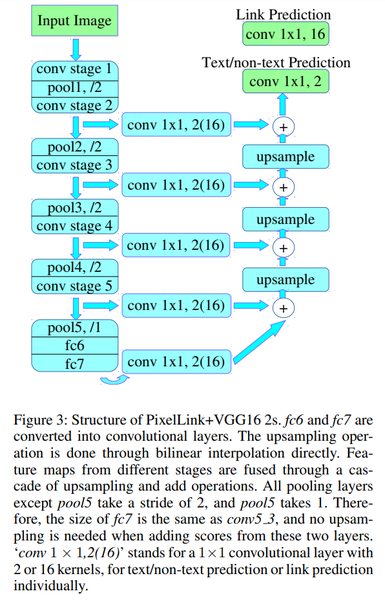

PixelLink의 전체적인 구조는 U-Net과 유사히다. 하지만 output으로 총 9가지의 정보를 얻는다.

위 그림의 녹색 부분이 input과 output을 의미하는데, output 중 하나는 Text/non-text Prediction을 위한 class segmentation map으로 해당 영역이 Text인지 Non-text인지 예측값을 의미하는 2개의 커널을 가진다. 나머지 8가지는 글자의 Pixel을 중심으로 인접한 8개의 Pixel에 대한 연결 여부를 의미하는 16개의 커널로 이루어진 Link Prediction map이다.

위 그림을 보면 conv 1X1, 2(16) 형태의 레이어가 U-Net 구조로 연결되어, 인접 pixel간 연결 구조가 지속적으로 유지되도록 하는 모델 구조임을 알 수 있다.

이를 통해서 인접한 pixel이 중심 pixel과 단어 단위로 연결된 pixel인지, 아니면 분리된 pixel인지 알 수 있으므로, 문자 영역이 단어 단위로 분리된 Instance segmentation이 가능해진다.

***
### 3. 최근의 방법들

**3.1. CRAFT**

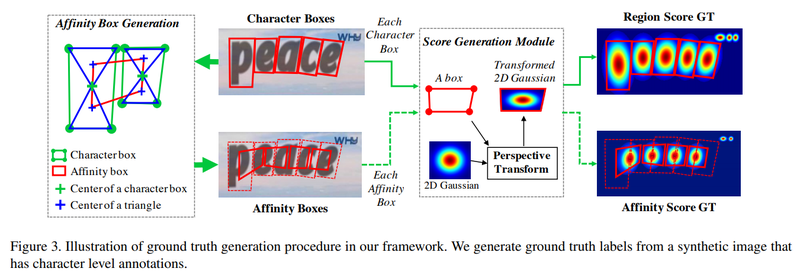

CRAFT는 문자(Character) 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 Segmentation 기반으로 구현한 방법이다. 문자의 영역을 boundary로 명확히 구분하지 않고, 가우시안 분포를 따르는 원형의 score map을 만들어서 배치시키는 방법으로 문자의 영역을 학습한다.

문자 단위 라벨을 가진 데이터셋이 많지 않기 때문에, 단어 단위의 정보만 있는 데이터셋에 대해 단어의 영역에 Inference를 한 후, 얻어진 문자 단위의 위치를 다시 학습에 활용하는 Weakly supervised learning을 활용했다.

***
정리하면,

CRAFT는 문자 검출(Character Region Awareness for Text Detection)을 위한 모델로, 텍스트 영역을 찾아내는 데 중점을 둔 텍스트 검출 방법입니다. CRAFT는 Segmentation 기반의 방법으로, 문자의 위치를 찾아내고 이를 연결하는 데에 가우시안 분포를 따르는 원형의 score map을 사용합니다. 여기에는 몇 가지 중요한 개념이 포함되어 있습니다:

**Segmentation 기반의 구현:**

CRAFT는 문자의 영역을 정확한 경계로 분리하는 대신, 원형의 score map을 통해 문자의 위치를 나타냅니다. 이것은 텍스트 영역을 픽셀 단위로 정확하게 분리하지 않고, 각 픽셀에 대한 확률 분포를 통해 텍스트의 존재 여부를 나타냄으로써 효과적으로 텍스트를 검출하는 방식입니다.

**가우시안 분포를 따르는 원형의 score map:**

텍스트의 위치를 나타내기 위해 가우시안 분포를 따르는 원형의 score map을 사용합니다. 이 score map은 각 픽셀이 텍스트의 일부인지 여부를 나타냅니다.

**Weakly supervised learning 활용:**

문자 단위의 라벨을 가진 데이터셋이 부족한 상황에서, CRAFT는 단어 단위의 정보만 있는 데이터셋을 활용합니다. 이를 위해 먼저 단어의 영역에 대한 추론을 수행하고, 이를 기반으로 문자 단위의 위치를 얻어냅니다.
얻어진 문자 단위의 위치 정보를 다시 학습에 활용함으로써, 모델은 더 나은 문자 검출 능력을 개발할 수 있습니다.
요약하면, CRAFT는 텍스트 검출을 위해 Segmentation 방식과 가우시안 score map을 사용하며, 데이터 부족 문제를 해결하기 위해 Weakly supervised learning을 도입하여 모델의 학습을 강화합니다.
***

**3.2. Pyramid Mask Text Detector**

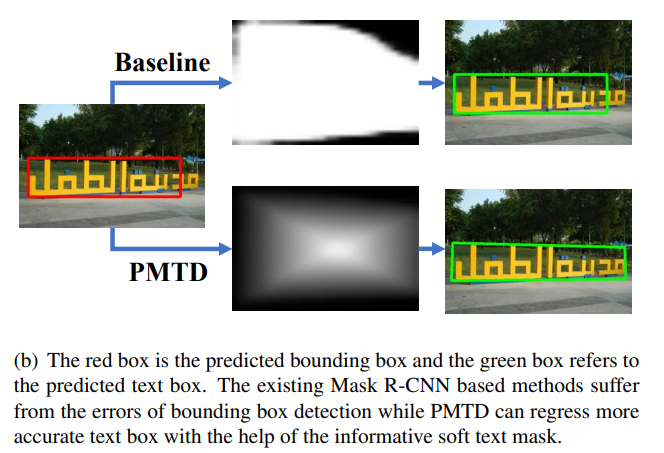

PMTD(Pyramid Mask Text Detector)는 Mask-RCNN의 구조를 활용하여 먼저 Text영역을 Region proposal network로 찾아낸다. 그다음 Box head에서 더 정확하게 regression 및 classification을 하고 Mask head에서 Instance의 Segmentation을 하는 과정을 거친다.

PMTD는 Mask 정보가 부정확한 경우를 반영하기 위해서 Soft-segmentation을 활용한다. 이전의 Mask-RCNN의 경우, 단어 영역이 Box head에 의해 빨간색으로 잡히면 위의 이미지의 baseline처럼 boundary를 모두 Text 영역으로 잡지만, PMTD는 단어의 사각형 배치 특성을 반영하여 피라미드 형태의 Score map을 활용한다. 따라서 Pyramid 형상의 Mask를 갖게 되어 Pyramid Mask Text detector라는 이름을 붙였다.
***
PMTD(Pyramid Mask Text Detector)는 텍스트 검출을 위한 모델로, Mask-RCNN 구조를 기반으로 한다고 설명되고 있습니다. 아래는 주요 내용을 해석한 것입니다:

**Mask-RCNN 구조 활용:**

PMTD는 Mask-RCNN의 구조를 사용하여 텍스트 영역을 찾아냅니다. Mask-RCNN은 객체 검출에 사용되며, Region Proposal Network(RPN)로 먼저 후보 영역을 제안하고, 그 다음 Box head에서 정확한 위치와 클래스를 예측하며, Mask head에서 객체의 세그멘테이션을 수행합니다.

**Soft-segmentation을 활용한 Mask 정보 보완:**

PMTD는 Mask 정보가 부정확한 경우를 보완하기 위해 Soft-segmentation을 사용합니다. 이것은 텍스트 영역의 경계를 부드럽게 만들어, 픽셀 단위로 텍스트와 배경의 확률을 나타냅니다. 이를 통해 부정확한 Mask 정보에 대응하고 정확성을 향상시킵니다.

**Pyramid 형태의 Score Map 활용:**

PMTD에서는 Mask 정보를 생성하기 위해 피라미드 형태의 Score map을 사용합니다. 이는 단어의 사각형 배치 특성을 반영하기 위한 것으로, 텍스트의 배치 구조를 더 잘 파악할 수 있게 합니다.
따라서, PMTD의 Mask는 Pyramid 형상을 가지게 되어 있습니다. 이는 단어의 배치에 대한 특성을 고려하여 세그멘테이션을 수행하며, 이로써 모델이 텍스트의 구조를 더 잘 이해하고 검출할 수 있도록 도와줍니다.

**PMTD의 이름:**

PMTD는 이러한 기능을 토대로 "Pyramid Mask Text Detector"라는 이름을 가지게 되었습니다. "Pyramid"은 피라미드 형태의 Score map을 나타내며, "Mask"는 텍스트의 세그멘테이션 정보를 의미합니다. "Text Detector"는 이 모델이 텍스트를 검출하는 데 중점을 둔다는 것을 나타냅니다.
***

## 16-4. Text recognition

***
### 1. Unsegmented Data

글자 이미지들은 문자의 순서대로 정보를 가지고 있다. 위의 "YOU"라는 이미지에서 "Y", "O", "U"의 영역은 이미지상에서 분리가 가능하다.

하지만 이와 다르게 분리에 드는 비용이 많이 들거나 어려워 Segmentation이 되어있지 않은 데이터를 Unsegmented data라고 한다. 이미지에서 문자를 읽어내는 OCR 분야뿐만 아니라 다른 분야들에서도 이런 데이터를 볼 수 있다.

예를 들어, 아래 그림과 같이 annotation이 제대로 안 된 음성데이터도 Unsegmented data의 한 종류이다. Waveform 파일에 대한 라벨이 "the sound of"라고 달려 있다고 할 때, 해당 waveform 파일에서 어디까지가 각각 "the", "sound", "of"인지의 경계가 명확하게 분할되어 있지 않은 경우를 생각할 수 있다.

Unsegmented Data에는 또 어떤 것들이 있을까? 그리고 이를 활용하기 위해서는 어떻게 해야 할까?

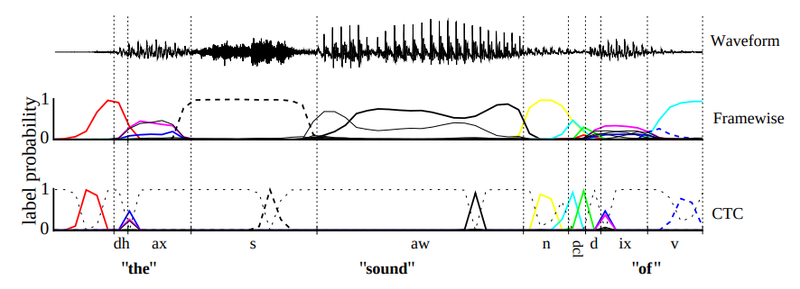

***
### 2. CNN과 RNN의 만남 CRNN

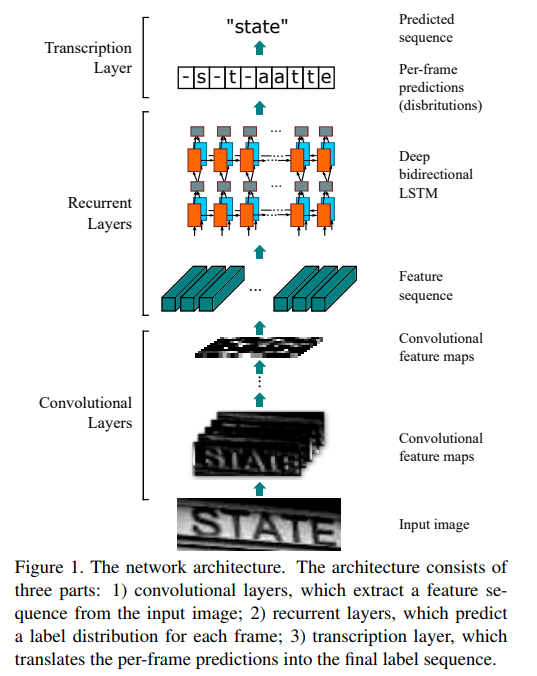

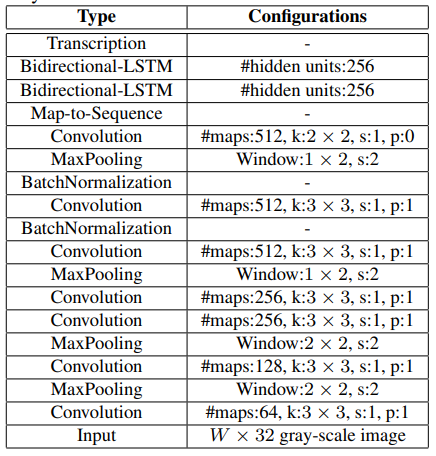

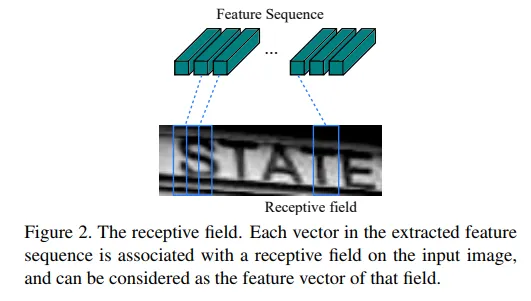

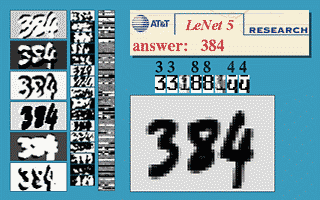

Unsegmented Data들이 가진 주요한 특징 중 하나는 segment되어 있지 않은 하위 데이터들끼리 시퀀스(sequence)를 이루고 있다는 점이다.

그래서 연구자들이 생각해 낸 방법 중 하나는 CNN(Convolutional neural network)과 RNN(Recurrent neural network)을 같이 쓰는 방법이다. 이런 모델을 CRNN이라고 한다.

문자 이미지에서 정보를 추출하기 위해서는 Feature Extractor가 필요하다. Feature Extractor로 사용되는 CNN 기반의 VGG 또는 ResNet과 같은 네트워크로부터 문자의 정보를 가진 Feature를 얻어낼 수 있다. 이렇게 추출된 Feature를 Map-To-Sequence를 통해 Sequence 형태의 feature로 변환한 후, 다양한 길이의 Input을 처리할 수 있는 RNN으로 넣는다.

RNN이 Feature로부터 문자를 인식하기 위해서는 문자 영역처럼 넓은 정보가 필요하기 때문에, LSTM으로 구성한다. 앞의 정보뿐만 아니라 뒤의 정보가 필요하기 때문에 이를 Bidirectional로 구성해서 Bidirectional LSTM을 사용했다. Bidirectional LSTM을 사용해 step마다 나오는 결과는 Transcription Layer에서 문자로 변환된다.

***
### 3. CTC

CRNN에서는 Step마다 Fully Connected Layer의 logit을 Softmax 함수에 넣어줌으로써 어떤 문자일 확률이 높은지 알 수 있다.

하지만 이 결과 그대로를 문자로 변환하면 기대한 것과 다른 결과가 나온다. 왜냐하면 모델의 Output은 24개의 글자로 이루어진 Sequence이지만, 실제 결과는 이와 다르기 때문이다.

예를 들어 "HELLO"라는 이미지가 들어오면 이것의 Output이 "HHHEEELLLOOOOO..."와 같이 24자의 sequence를 보게 된다.

그렇다면 이 24자의 Sequence를 실제 인식 결과로 바꾸기 위해서는 어떤 방법을 써야 할까?

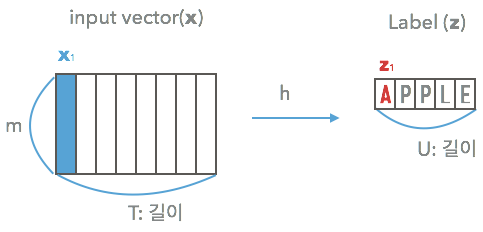

CRNN에서는 **Unsegmented Data를 위해 CTC(Connectionist Temporal Classification)** 를 활용한다. CTC는 Unsegmented data와 같이 Input과 Output이 서로 다른 Length의 Sequence를 가질 때, 이를 Align 없이 활용하는 방법이다.

논문에서 언급하는 CTC의 핵심인 모델의 Output에서 Label sequence의 확률을 구할 수 있는 방법에 대해 알아보겠다.

위에서 본 "HHHEEELLLOOOOO..."를 "HELLO"로 만들기 위해서는 중복되는 단어인 "HHHH..."나 "EEE...", "LLL..."들을 "H", "E", "L" 등으로 바꿔볼 수 있다. 그러면 "HELO"가 될 것이다. 그렇다면 "L"이 두 번 중복되는 경우에는 어떻게 구분할 수 있을까?

앞서 봤던 Label Encode에서 이렇게 같은 문자를 구분하기 위한 Blank를 중복된 라벨 사이를 구분하기 위해 넣어준다.

아래 그림은 Blank token을 '-'로 대신하여 Output을 만드는 Decoder를 의미한다. Decode 후에 중복을 제거하고, 인식할 문자가 아닌 값을 지워주면 "HELLO"라는 결과를 얻을 수 있다.

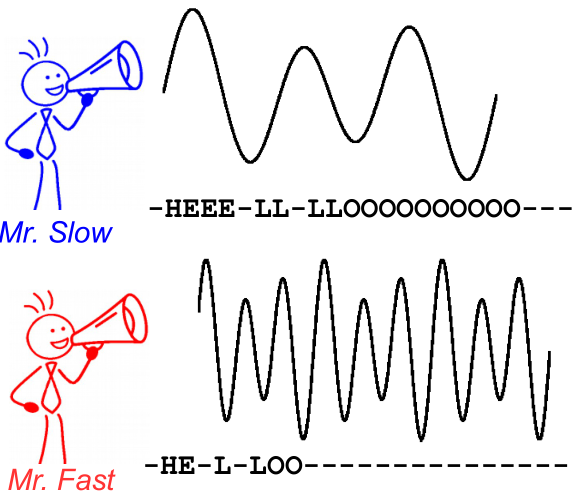

***
### 4. TPS

책이 아닌 거리의 글자를 읽을 때, OCR이 어려워지는 이유는 불규칙한 방향이나 휘어진 진행 방향 때문이다.

논문 Robust Scene Text Recognition With Automatic Rectification에서는 Thin Plate Spline (TPS) Transformation을 적용하여 입력 이미지를 단어 영역에 맞게 변형 시켜 인식이 잘되도록 해준다.

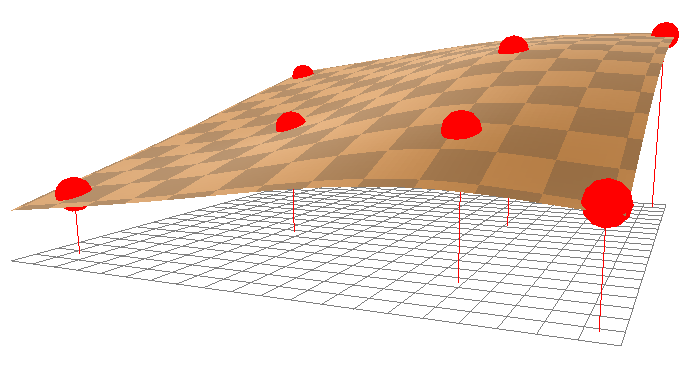

Thin plate spline은 control point를 정의하고 해당 point들이 특정 위치로 옮겨졌을 때, 축 방향의 변화를 interpolation하여 모든 위치의 변화를 추정해낸다. 이를 통해서 전체 이미지 pixel의 변화를 control point로 만들어낼 수 있다.

논문에서는 Control point 20개를 미리 정의한다. Spatial Transformer Network를 통해서 Control point가 얼마나 움직여야 하는지 예측하는 네트워크를 아래 그림과 같이 Recognition model 앞단에 붙여 입력 이미지를 정방향으로 맞춰준다. TPS 연산은 미분 가능한 연산이기 때문에 이 모듈을 Recognition model 앞단에 붙여서 학습이 바로 가능하다.

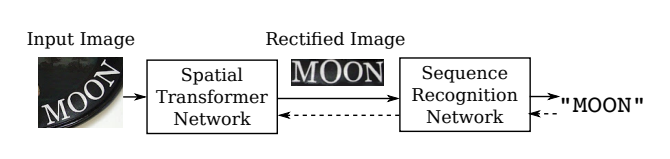

***
## 16-5. Text recognition + Attention

### 1. Attention sequence prediction

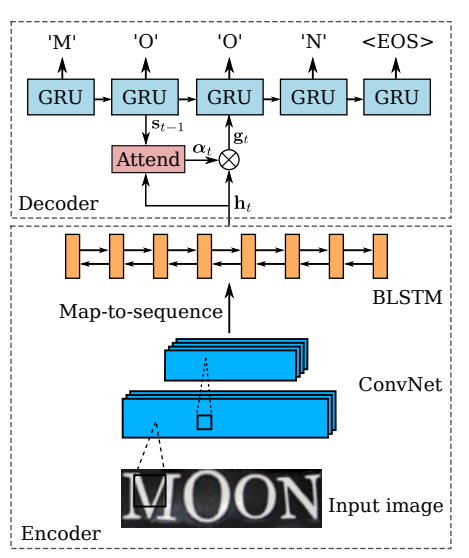

CTC를 활용한 CRNN의 경우, column에 따라서 prediction된 Label의 중복된 것들을 제거해 줌으로써 원하는 형태의 label로 만들어주었다.

Attention기반의 sequence prediction은 문장의 길이를 고정하고, 입력되는 Feature에 대한 Attention을 기반으로 해당 글자의 Label을 prediction한다. RNN으로 Character label을 뽑아낸다고 생각하면 되는데, 첫 번째 글자에서 입력 feature에 대한 Attention을 기반으로 label을 추정하고, 추정된 label을 다시 입력으로 사용하여 다음 글자를 추정해내는 방식이다.

이때 20글자를 뽑겠다고 정하게 되면 "YOU"같은 경우에는 3글자를 채우고 빈자리가 문제가 되는데요, 이러한 경우를 위해 미리 정해둔 Token을 사용한다. 이 Token에는 처음에 사용되는 "start" token과 끝에 사용되는 "end" token이 있다. 필요에 따라서 예외처리나 공백을 위한 token을 만들어서 사용하기도 한다.

Attention 기반의 Recognition이 더욱 좋은 성능을 보이고 있는 것을 위 링크에 소개한 네이버 Clova의 논문 'What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis'에서 확인할 수 있다. 이 논문에서는 CTC와 attention만이 아니라 TPS 등 Recognition에서 쓰이는 다양한 모듈들을 비교 평가를 하고 있다.
***
정리하면, 

Scene Text Recognition (STR) 모델에서 사용되는 두 가지 다른 접근 방식인 CTC (Connectionist Temporal Classification)와 Attention 기반의 CRNN (Convolutional Recurrent Neural Network)에 대한 설명과, Attention 기반의 모델이 높은 성능을 보이고 있는 것을 언급한 것입니다. 아래는 각 부분에 대한 해석입니다:

**CTC를 활용한 CRNN:**

CRNN은 Convolutional, Recurrent, 그리고 Fully Connected 레이어로 구성된 네트워크입니다.
CTC는 CRNN에서 주로 활용되는 디코딩 방식 중 하나로, 출력된 sequence에 대해 중복된 라벨을 제거하여 원하는 형태의 라벨로 만들어줍니다. 이는 텍스트 인식에서 텍스트의 길이가 가변적인 경우에 유용하게 사용됩니다.

**Attention 기반의 Sequence Prediction:**

Attention 기반의 모델은 입력 Feature에 대한 Attention을 활용하여 각 글자의 Label을 예측합니다. RNN을 통해 글자 단위의 라벨을 예측하면서, 이전에 예측된 라벨을 다시 입력으로 활용하여 다음 글자를 예측합니다.
글자의 길이를 고정하고, "start"와 "end" token을 사용하여 예외적인 경우에 대비합니다. 이렇게 함으로써 모델은 출력 글자의 길이를 사전에 알고 있지 않아도 처리할 수 있습니다.

**Attention 기반 모델의 우수성:**

논문 'What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis'에서는 Scene Text Recognition 모델들을 비교하고 있습니다. 이 논문에 따르면, Attention 기반의 모델이 CTC와 같은 다른 모듈과 비교했을 때 더 좋은 성능을 보인다고 언급하고 있습니다.
논문에서는 TPS (Thin-Plate Spline)와 같은 다양한 Recognition에 사용되는 모듈들을 비교하여 어떤 모델이 높은 성능을 보이는지에 대한 분석을 제시하고 있습니다.
따라서, Attention 기반의 모델이 텍스트 인식에서 좋은 성능을 보인다는 논문의 내용을 참고하여 어떤 모델을 선택할지 고려할 수 있습니다.
***
여기서 **Attention** 다시 정리하면,

Attention은 딥러닝 모델이 입력 데이터의 특정 부분에 "주의를 기울이는" 메커니즘을 나타냅니다. 주로 시퀀스 데이터를 처리하는 데 사용되며, 모델이 특정 위치에 더 많은 가중치를 두도록 도와줍니다. Attention 메커니즘은 주로 자연어 처리 (NLP) 및 컴퓨터 비전 분야에서 활용됩니다.

간단한 예로, Attention 메커니즘이 텍스트 번역 작업에 사용될 때를 생각해봅시다. Attention을 사용하면 모델은 번역할 때 입력 문장의 각 단어에 "주의"를 기울여 출력 문장을 생성합니다. 이는 번역 과정에서 각 입력 단어가 출력 단어에 미치는 영향을 동적으로 조절하게 해줍니다.

일반적으로 Attention은 다음과 같은 구성요소로 이루어집니다:

**Query(Q), Key(K), Value(V):**

Attention 메커니즘은 Query(Q), Key(K), Value(V)의 세 가지 요소를 사용합니다. 이들은 주로 선형 변환(Linear Transformation)을 통해 생성됩니다.
Query는 어떤 위치에 주의를 기울일 것인지를 결정합니다.
Key는 주의를 기울일 대상의 위치 정보를 담고 있습니다.
Value는 실제로 해당 위치에서의 정보를 담고 있습니다.

**Attention Score:**

Query와 Key 간의 관련성을 계산하는 Attention Score가 생성됩니다. 이는 주의를 기울일 정도를 나타냅니다.
Attention Score는 보통 내적(dot product), 유클리드 거리 등을 사용하여 계산됩니다.

**Softmax 및 Weighted Sum:**

Attention Score에 소프트맥스 함수를 적용하여 각 위치에 대한 확률값을 얻습니다. 이를 이용하여 Value에 대한 가중합(Weighted Sum)을 계산합니다.
이 가중합이 최종적으로 Attention이 적용된 결과를 나타냅니다.
Attention은 기존의 RNN(Recurrent Neural Network)이나 CNN(Convolutional Neural Network)과 함께 사용되어 모델이 더 좋은 성능을 발휘하도록 도와줍니다. 주로 번역, 이미지 캡션 생성, 음성 처리 등 다양한 작업에서 효과적으로 적용되고 있습니다.

***
### 2. Transformer와 함께!

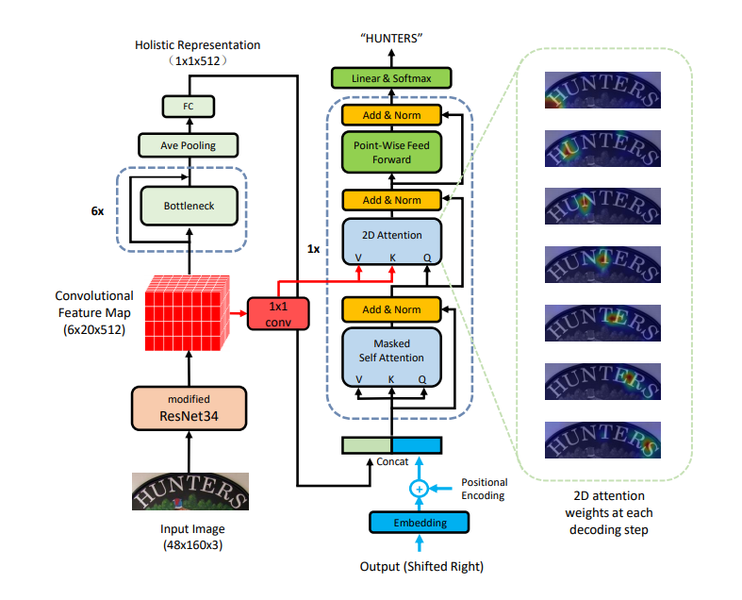

Transformer도 Recognition 모델에 활용되기 시작한다. 다양한 논문에서 시도되고 있지만 "A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition"가 대표적인 논문이다.

위 논문에서는 Irregular text를 잘 인식하기 위해서 2d space에 대한 attention을 활용하여 문자를 인식하기 위해 Transformer를 활용한다.

Transformer는 Query, Key, Value라는 개념을 통해서 Self-Attention을 입력으로부터 만들어낸다. 이를 통해서 입력에서 중요한 Feature에 대해 Weight를 주게 되죠. Attention의 핵심은 Decoder의 현재 포지션에서 중요한 Encoder의 State에 가중치가 높게 매겨진다는 점이다.

위에서 Attention이 시각화된 이미지를 눈으로 볼 수 있는데요, Decoder의 각 Step에 따라 입력에 대한 Visual Attention이 시각화된 모습이다.

**2D Attention :**

1D Attention은 시퀀스 데이터에서 각 단어의 중요도를 계산할 때 사용되는데, 이는 1차원의 일렬로 늘어선 데이터에 적용하는 방식입니다.

반면에 2D Attention은 입력 이미지의 모든 위치에 대해 각 위치가 출력에 미치는 영향을 계산합니다. 이를 통해 모델이 이미지의 중요한 부분을 선택하고, 중요하지 않은 부분을 무시할 수 있도록 합니다.
***
정리하면,

이 문장은 "A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition"이라는 논문을 통해 Transformer가 Recognition 모델에 적용되는 방식을 설명하고 있습니다. 아래는 주요 내용에 대한 해석입니다:

**Irregular Text Recognition과 Transformer 활용:**

Irregular Text Recognition은 일반적인 규칙적인 형태가 아닌, 불규칙한 모양과 배치를 갖는 텍스트를 인식하는 작업을 의미합니다.
"A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition" 논문은 Transformer를 활용하여 Irregular Text Recognition 문제에 접근하고 있습니다.

**2D Space에 대한 Attention 활용:**

Irregular한 텍스트에 대한 인식을 위해, 2D 공간에 대한 Attention을 사용합니다. 이는 입력 이미지의 텍스트 영역을 2차원으로 고려하여 Transformer의 Self-Attention 메커니즘을 적용함을 의미합니다.

**Transformer의 Self-Attention:**

Transformer는 Query, Key, Value라는 개념을 사용하여 Self-Attention을 생성합니다. 이는 입력으로부터 중요한 특징에 대한 가중치를 동적으로 부여하는 메커니즘입니다.
Query, Key, Value는 선형 변환을 통해 얻어지며, Attention Score는 이들 간의 관련성을 나타내는데 사용됩니다.
중요한 특징에 높은 가중치를 주어 모델이 입력에서 주목해야 할 부분을 동적으로 선택하게 합니다.

**Visual Attention 시각화:**

Attention의 시각화는 모델이 각 Decoder의 단계에서 입력에 대한 어떤 부분에 주의를 기울였는지를 시각적으로 확인할 수 있도록 합니다.
Decoder의 각 단계에서 입력 이미지의 어느 부분에 모델이 집중했는지를 나타낸 이미지를 눈으로 확인할 수 있습니다.
이러한 방식으로 Transformer를 Recognition 모델에 적용함으로써 Irregular한 텍스트에 대한 효과적인 인식이 가능하도록 합니다.

***
여기서 Transformer 다시 정리하면,

Transformer는 주로 자연어 처리 (NLP)와 이미지 처리 분야에서 사용되는 딥러닝 모델 중 하나입니다. "Attention Is All You Need"이라는 논문에서 처음으로 소개되었으며, 기존의 순환 신경망(RNN)이나 장단기 메모리(LSTM)와 같은 구조를 사용하지 않고, 오로지 Attention 메커니즘을 기반으로 하는 모델입니다. Transformer는 특히 시퀀스 데이터를 처리하는 데 뛰어난 성능을 보이며, 번역, 챗봇, 문장 생성, 이미지 분류, 텍스트 인식 등 다양한 작업에 적용되고 있습니다.

Transformer의 주요 특징은 다음과 같습니다:

**Self-Attention 메커니즘:**

Transformer에서는 Self-Attention 메커니즘이 사용됩니다. 이는 입력의 각 위치가 다른 위치와 얼마나 관련되어 있는지 동적으로 계산하여 중요한 정보에 가중치를 부여합니다.
Self-Attention은 한 번에 모든 입력 위치 간의 관계를 고려할 수 있어서, 긴 시퀀스에 대한 정보 처리에서 RNN과 LSTM보다 효율적입니다.

**멀티헤드 어텐션:**

Self-Attention을 여러 개의 헤드로 나누어 병렬로 계산함으로써 모델의 표현력을 향상시키는 멀티헤드 어텐션을 도입하였습니다.
각 헤드는 서로 다른 관점에서 정보를 추출하고, 이를 결합하여 더 풍부한 표현을 얻을 수 있습니다.

**포지셔널 인코딩:**

Transformer는 입력 시퀀스의 단어들이 순서에 대한 정보를 가지고 있지 않기 때문에, 포지셔널 인코딩을 도입하여 단어의 상대적인 위치 정보를 모델에 전달합니다.

**인코더와 디코더 구조:**

Transformer는 인코더와 디코더로 구성되어 있습니다. 인코더는 입력 시퀀스를 잘 파악한 표현으로 변환하고, 디코더는 해당 표현을 기반으로 출력 시퀀스를 생성합니다.
번역 작업과 같은 시퀀스-투-시퀀스 (Seq2Seq) 문제에서 주로 사용됩니다.

**사용 범위 확대:**

초기에는 NLP에서의 번역 등에 사용되었지만, 현재는 이미지 처리에도 활발하게 적용되고 있습니다. 비전 Transformer 모델들은 이미지 분류, 객체 검출, 세그멘테이션 등에서 좋은 성능을 보이고 있습니다.
Transformer의 등장은 딥러닝 분야에서 혁명적인 변화를 가져왔으며, 다양한 응용 분야에 활용되고 있습니다.